In [1]:
# This file explores any correlations between the listing occupancy (how many people allowed to stay there), the number of beds and baths, and price.
# We suspected that listings that could accommodate larger numbers of people would have correspondingly higher prices. 
# However, this was not true.  We did not use the graphs in this file in the final presentation, but retained the code
# as it was an important part of our exploration and analysis.
# The only correlations we discovered in this analysis related to number of beds, number of baths, and number of guests accomodated. But none of theses correlated
# to price.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt  
import scipy.stats as st 
import numpy as np 
import datetime as dt 
import seaborn as sns

In [3]:
# increase max number of columns and rows visible and read in master data file
pd.set_option('display.max_columns', 45)
pd.set_option('display.max_rows', 45)
price_df = pd.read_csv('../BM_files/all_listings_df')
price_df.head()

id last_scraped                                        description  \
0  360   2023-09-24  Enjoy the famous Colorado weather and unplug i...   
1  364   2023-09-24  Modern 1,000 square foot loft in the heart of ...   
2  590   2023-09-24  Large guest room in my home, where I also live...   
3  592   2023-09-24  This room is in the basement.  It does not hav...   
4  686   2023-09-24  Thanks for visiting my Queen Bed Room site for...   

                               neighborhood_overview  host_id  host_since  \
0  The cottage is located in the center of Lower ...      666  2008-07-08   
1  Ten brewpubs within walking distance, two grea...      783  2008-07-11   
2  I love the diversity of my neighborhood and it...      933  2008-07-21   
3                                                NaN      933  2008-07-21   
4  I love my Uptown neighborhood, which is within...      990  2008-07-23   

  host_location  host_response_time host_response_rate host_acceptance_rate  \
0    Denver, CO      within an hour               100%                  97%   
1    Denver, CO                 NaN                NaN                  NaN   
2    Denver, CO      within an hour               100%                  95%   
3    Denver, CO      within an hour               100%                  95%   
4    Denver, CO  within a few hours               100%                 100%   

  host_is_superhost  host_listings_count  host_total_listings_count  \
0                 t                    3                          4   
1                 f                    1                          1   
2                 t                    2                          2   
3                 t                    2                          2   
4                 t                    2                          4   

  host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
0                    t                      t               Highland   
1                    t                      t            Five Points   
2                    t                      t        North Park Hill   
3                    t                      t        North Park Hill   
4                    t                      t     North Capitol Hill   

    latitude   longitude         property_type        room_type  accommodates  \
0  39.766415 -105.002098     Entire guesthouse  Entire home/apt             3   
1  39.766720 -104.979060           Entire loft  Entire home/apt             3   
2  39.755110 -104.911090  Private room in home     Private room             3   
3  39.754810 -104.911060  Private room in home     Private room             2   
4  39.746950 -104.978380  Private room in home     Private room             2   

   bathrooms  bathrooms_text  bedrooms  beds  price has_availability  \
0        NaN          1 bath       2.0   2.0   90.0                t   
1        NaN       1.5 baths       1.0   1.0  179.0                t   
2        NaN   1 shared bath       NaN   1.0   64.0                t   
3        NaN   1 shared bath       NaN   1.0   57.0                t   
4        NaN  1 private bath       NaN   2.0   33.0                t   

   availability_30  availability_60  availability_90  availability_365  \
0                4               27               57               147   
1               23               53               83               358   
2                5               27               53               233   
3                0                0                0               158   
4                0                0               13               288   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
0                179                      7                       0   
1                 87                      0                       0   
2                712                     43                       2   
3                168                      1                       0   
4                256                     

In [4]:
# row count
# price_df

In [5]:
# check for null values in 'price'
null_counts_price = price_df['price'].isna().sum()
print(null_counts_price)

0


In [22]:
# check for null values in 'accommodates'
null_counts_occ = price_df['accommodates'].isna().sum()
print(null_counts_occ)

0


In [6]:
# Create occupancy dataframe with relevant columns

occ_df = pd.DataFrame(price_df[["id", "price", "accommodates", "bathrooms_text", "beds", "city"]])

occ_df = occ_df.set_index("id")
occ_df

price  accommodates  bathrooms_text  beds      city
id                                                                     
360                  90.0             3          1 bath   2.0    Denver
364                 179.0             3       1.5 baths   1.0    Denver
590                  64.0             3   1 shared bath   1.0    Denver
592                  57.0             2   1 shared bath   1.0    Denver
686                  33.0             2  1 private bath   2.0    Denver
...                   ...           ...             ...   ...       ...
979474665987354279  258.0             8         2 baths   4.0  Portland
980422903985425172   99.0             3          1 bath   2.0  Portland
980439098128842446  165.0             6       2.5 baths   3.0  Portland
980549321160587970  195.0             6         2 baths   3.0  Portland
980724230458451699  269.0             8         2 baths   4.0  Portland

[22851 rows x 5 columns]

In [7]:
# in 'bathrooms_text' column convert various 'half-bath' wording with .5 to be able to have a numeric value for number of bathrooms
# split bathrooms_text column into 2 columns to separate number and words, use RegEx to parse numbers from words
# convert new 'bath_number' column to float data type

occ_df['bathrooms_text'] = occ_df['bathrooms_text'].replace({'Half-bath': '.5 bath ', 'Private half-bath': '.5 private bath', 'Shared half-bath': '.5 shared bath'})
occ_df[['bath_number', 'bath_text']] = occ_df['bathrooms_text'].str.split(r'(\d+\.?\d*)', n=1, expand=True).iloc[:, 1:3]
occ_df['bath_number'] = occ_df['bath_number'].astype(float)

occ_df

price  accommodates  bathrooms_text  beds      city  \
id                                                                        
360                  90.0             3          1 bath   2.0    Denver   
364                 179.0             3       1.5 baths   1.0    Denver   
590                  64.0             3   1 shared bath   1.0    Denver   
592                  57.0             2   1 shared bath   1.0    Denver   
686                  33.0             2  1 private bath   2.0    Denver   
...                   ...           ...             ...   ...       ...   
979474665987354279  258.0             8         2 baths   4.0  Portland   
980422903985425172   99.0             3          1 bath   2.0  Portland   
980439098128842446  165.0             6       2.5 baths   3.0  Portland   
980549321160587970  195.0             6         2 baths   3.0  Portland   
980724230458451699  269.0             8         2 baths   4.0  Portland   

                    bath_number      bath_text  
id                                              
360                         1.0           bath  
364                         1.5          baths  
590                         1.0    shared bath  
592                         1.0    shared bath  
686                         1.0   private bath  
...                         ...            ...  
979474665987354279          2.0          baths  
980422903985425172          1.0           bath  
980439098128842446          2.5          baths  
980549321160587970          2.0          baths  
980724230458451699          2.0          baths  

[22851 rows x 7 columns]

In [8]:
#test to make sure bath wording got updated correctly

words = ['Private half-bath', 'Shared half-bath', 'Half-bath']

test_df = occ_df[occ_df['bathrooms_text'].isin(words)]
test_df

Empty DataFrame
Columns: [price, accommodates, bathrooms_text, beds, city, bath_number, bath_text]
Index: []

In [9]:
# Use value_counts of bathrooms_text to see full list of values. Use this to check if fully converted all items into numeric values above.
occ_df['bathrooms_text'].value_counts()

bathrooms_text
1 bath              11192
2 baths              3277
2.5 baths            1293
1 private bath       1216
1 shared bath        1080
3 baths               898
3.5 baths             887
1.5 baths             877
4 baths               606
2 shared baths        248
0 baths               241
1.5 shared baths      212
4.5 baths             198
0 shared baths        180
8 baths                65
5 baths                64
6 baths                62
7 baths                39
5.5 baths              33
6.5 baths              24
9 baths                23
2.5 shared baths       22
4 shared baths         20
3 shared baths         18
12 baths                9
.5 bath                 8
7.5 baths               7
16 baths                7
8.5 baths               6
.5 private bath         4
9.5 baths               4
11 shared baths         4
12.5 baths              4
13.5 baths              3
3.5 shared baths        3
17.5 baths              2
5 shared baths          2
18 baths               

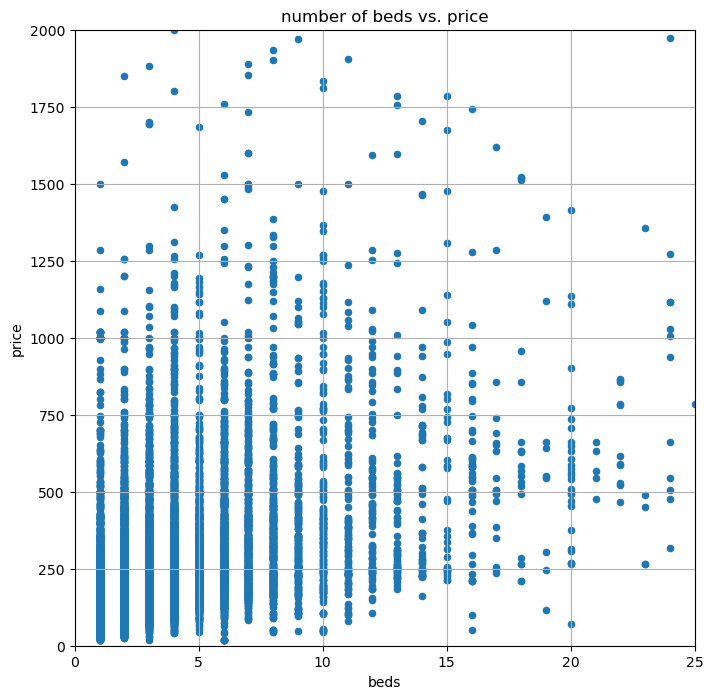

In [10]:
# scatter plot comparing number of beds to price. There is a wide range of prices for all numbers of beds.

occ_df.plot(kind='scatter', x='beds', y='price', grid=True, figsize=(8,8),
            title="number of beds vs. price", ylim=(0,2000), xlim=(0,25))
            
plt.show()

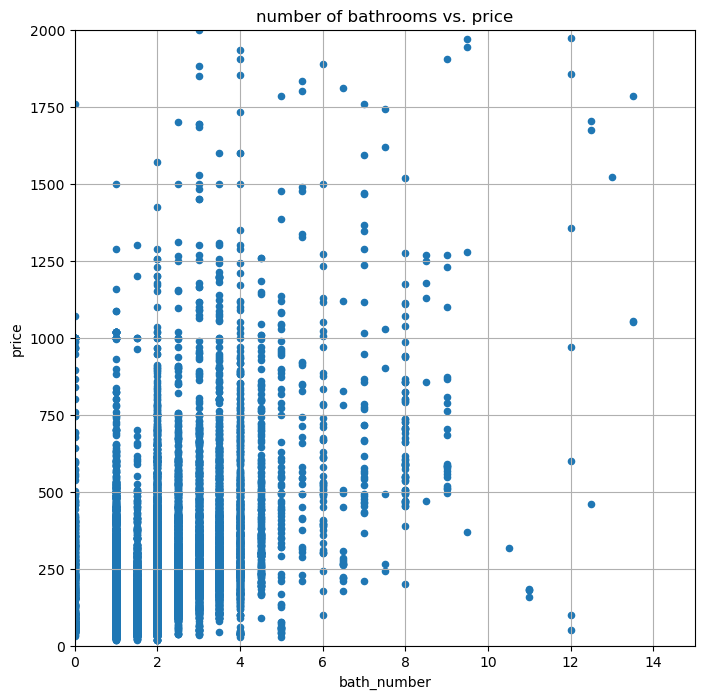

In [11]:
# scatter plot comparing number of bathrooms to price. There is a wide range of prices for all numbers of bathrooms.

occ_df.plot(kind='scatter', x='bath_number', y='price', grid=True, figsize=(8,8),
            title="number of bathrooms vs. price", ylim=(0,2000), xlim=(0,15))
            
plt.show()

In [12]:
###############################################################################################################################

In [13]:
# Use Pandas to calculate the quartiles, IQR, and median
quartiles = occ_df['bath_number'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of number of bathrooms is: {lowerq}")
print(f"The upper quartile of number of bathrooms is: {upperq}")
print(f"The interquartile range of number of bathrooms is: {iqr}")
print(f"The the median of number of bathrooms is: {quartiles[0.5]} ")

The lower quartile of number of bathrooms is: 1.0
The upper quartile of number of bathrooms is: 2.0
The interquartile range of number of bathrooms is: 1.0
The the median of number of bathrooms is: 1.0 


In [14]:
# check max and min price value
max_value = occ_df['bath_number'].max()
min_value = occ_df['bath_number'].min()
print(max_value)
print(min_value)

18.0
0.0


In [15]:
# use the IQR to determine upper/lower bound for outliers
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

Values below -0.5 could be outliers.
Values above 3.5 could be outliers.


In [16]:
# Look at correlation between price, bath number, occupancy, and beds.

occ_for_corr_df = pd.DataFrame(occ_df[["price", "bath_number", "beds", "accommodates"]])
occ_corr = occ_for_corr_df.corr()
occ_corr.unstack().sort_values()

price         beds            0.101056
beds          price           0.101056
price         accommodates    0.111440
accommodates  price           0.111440
price         bath_number     0.113429
bath_number   price           0.113429
              beds            0.733560
beds          bath_number     0.733560
bath_number   accommodates    0.739236
accommodates  bath_number     0.739236
beds          accommodates    0.824436
accommodates  beds            0.824436
price         price           1.000000
bath_number   bath_number     1.000000
beds          beds            1.000000
accommodates  accommodates    1.000000
dtype: float64

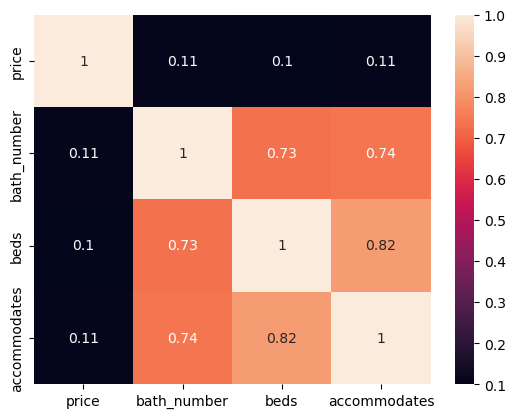

In [17]:
# There is a correlation between the number of beds, the number of baths, and the number accommodated. But none correlate to price
# create heatmap to visualize

matrix = occ_corr.round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [18]:
occ_for_corr_df

price  bath_number  beds  accommodates
id                                                        
360                  90.0          1.0   2.0             3
364                 179.0          1.5   1.0             3
590                  64.0          1.0   1.0             3
592                  57.0          1.0   1.0             2
686                  33.0          1.0   2.0             2
...                   ...          ...   ...           ...
979474665987354279  258.0          2.0   4.0             8
980422903985425172   99.0          1.0   2.0             3
980439098128842446  165.0          2.5   3.0             6
980549321160587970  195.0          2.0   3.0             6
980724230458451699  269.0          2.0   4.0             8

[22851 rows x 4 columns]

In [19]:
###############################################################################################################################

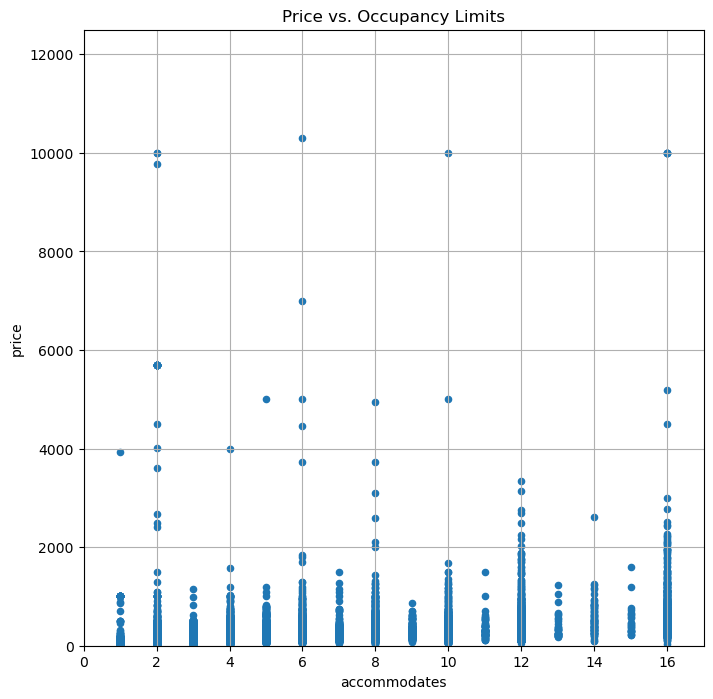

In [20]:
# Look at occupancy ('accomodates' column) as relates to price

occ_df.plot(kind="scatter", x="accommodates", y="price", grid=True, figsize=(8,8), 
            title="Price vs. Occupancy Limits", ylim=(0,12500), xlim=(0,17))
plt.show()

In [21]:
##############################################################################################################################